Need to mount the drive to acess the dataset since the dataset is large.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install python_speech_features

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5879 sha256=a6f3adf76a2455596659cec074bedfcfeb0b472eacc7fa5863ac60cdfa80dd97
  Stored in directory: c:\users\lenovo\appdata\local\pip\cache\wheels\5a\9e\68\30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


###Imports and Load data

In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from python_speech_features import mfcc
import seaborn as sns
import librosa.display
import librosa

import os
import math
import pickle
import random
import operator


import math
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Additional libraries for data preprocessing and visualization
import cv2
from sklearn.model_selection import train_test_split


In [4]:
import os
Root = "/content/drive/MyDrive/Data"
os.chdir(Root)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Data'

In [2]:
data = pd.read_csv('features_3_sec.csv')

In [13]:
data.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.051501            65671.875673  ...   64.748276   
2              2084.565132            75124.921716  ...   67.336563   
3              1960.039988            82913.639269  ...   47.739452   
4              1948.503884            60204.020268  ...   30.336359   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1    -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2    -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3    -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4     0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   

   mfcc20_mean  mfcc20_var  label  
0    -0.243027   43.771767  blues  
1     5.784063   59.943081  blues  
2     2.517375   33.105122  blues  
3     3.630866   32.023678  blues  
4     0.536961   29.146694  blues  

[5 rows x 60 columns]

Removed 11 low-variance features


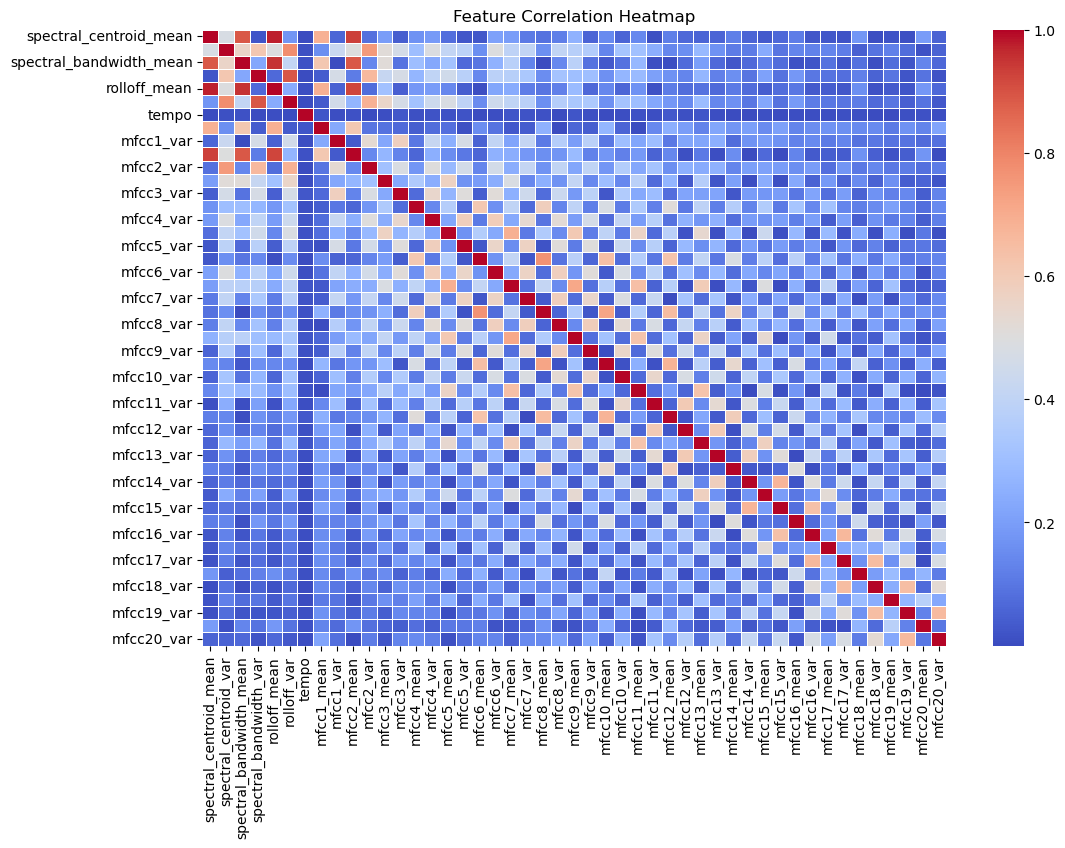

Removed 1 highly correlated features: ['rolloff_mean']


In [3]:
# Implement feature selection techniques #27

from sklearn.feature_selection import VarianceThreshold

# finding low variance features (those features whose value does not vary much for each instance)
X = data.drop(columns=['filename', 'label'])
selector = VarianceThreshold(threshold=0.01)
X_low_var = X.loc[:, selector.fit(X).get_support()]

print(f"Removed {X.shape[1] - X_low_var.shape[1]} low-variance features")

#finding correlation between the rest of the columns
corr_matrix = X_low_var.corr().abs()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop these features
X_corr_filtered = X_low_var.drop(columns=to_drop)
print(f"Removed {len(to_drop)} highly correlated features: {to_drop}")

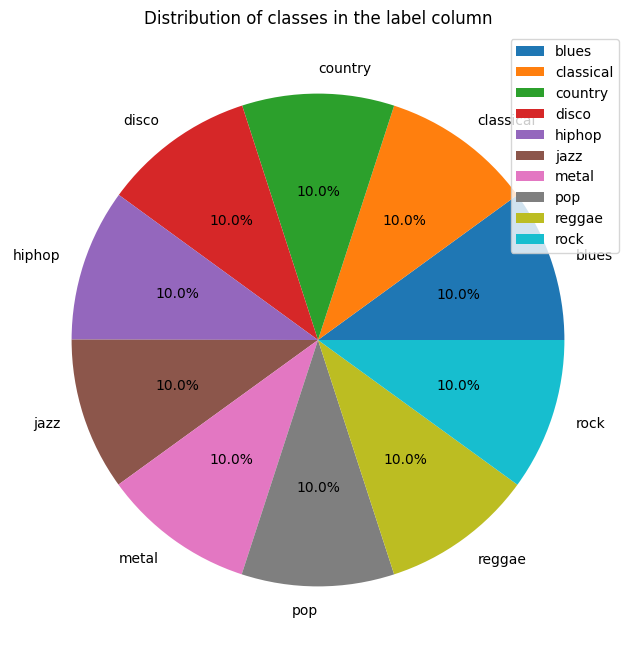

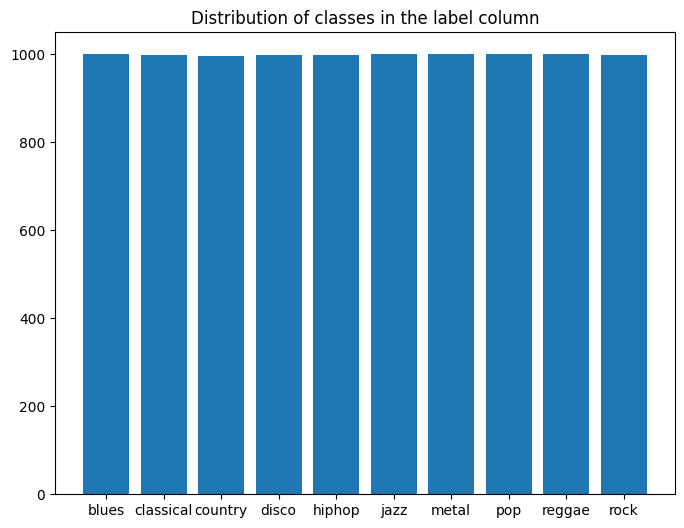

In [6]:
#visualize the distribution of classes in the label column
count = [] #count of each data value
labels = data['label'].unique() #distinct label values

for i in labels:
  count.append(data[data['label']==i]['label'].count()) #storing count and labels in same order

#pie chart
plt.figure(figsize=(8, 8)) #size of figure
plt.pie(count, labels = labels,autopct='%1.1f%%') #pie chart labels and corresponding values
plt.title('Distribution of classes in the label column') #title of pie chart
plt.legend() #displays the legend
plt.show() #displays the pie chart

#bar plot
plt.figure(figsize=(8, 6)) #size of figure
plt.bar(labels, count) #(x axis, y axis)
plt.title('Distribution of classes in the label column') # title of bar plot
plt.show() #displays the graph



### Random Forest Model

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

data = data.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
scaled_df = pd.DataFrame(np_scaled, columns = cols)
scaled_df.head()

length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0     0.0          0.355399         0.716757  0.293133  0.107955   
1     0.0          0.367322         0.670347  0.253040  0.044447   
2     0.0          0.373159         0.728067  0.296753  0.141663   
3     0.0          0.399349         0.677066  0.298024  0.075042   
4     0.0          0.355668         0.689113  0.322308  0.052149   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                0.262173               0.034784                 0.459205   
1                0.270969               0.018716                 0.470831   
2                0.265293               0.023073                 0.494051   
3                0.238427               0.023187                 0.455246   
4                0.233460               0.016451                 0.451651   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_mean  mfcc16_var  \
0                0.094130      0.346153  ...     0.363613    0.056198   
1                0.052261      0.363722  ...     0.468596    0.092912   
2                0.059922      0.378215  ...     0.479681    0.096704   
3                0.066234      0.329587  ...     0.386258    0.067995   
4                0.047830      0.318453  ...     0.438567    0.042500   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0     0.397172    0.066062     0.371828    0.055344     0.380831    0.026797   
1     0.351681    0.074001     0.362068    0.076365     0.418452    0.082414   
2     0.420979    0.050639     0.400536    0.067509     0.433742    0.043841   
3     0.387474    0.050617     0.380430    0.050030     0.405824    0.041898   
4     0.460314    0.083860     0.388590    0.076524     0.409019    0.020763   

   mfcc20_mean  mfcc20_var  
0     0.506746    0.047781  
1     0.593029    0.065548  
2     0.546264    0.036062  
3     0.562204    0.034873  
4     0.517913    0.031713  

[5 rows x 58 columns]

In [8]:
# Assuming X contains your features and y contains the corresponding labels
X_train, X_test, y_train, y_test = train_test_split(scaled_df, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)



Classification Report:
              precision    recall  f1-score   support

       blues       0.87      0.87      0.87       208
   classical       0.94      0.98      0.96       203
     country       0.80      0.84      0.82       186
       disco       0.85      0.83      0.84       199
      hiphop       0.92      0.89      0.90       218
        jazz       0.86      0.93      0.89       192
       metal       0.87      0.95      0.91       204
         pop       0.92      0.95      0.93       180
      reggae       0.92      0.88      0.90       211
        rock       0.89      0.72      0.79       197

    accuracy                           0.88      1998
   macro avg       0.88      0.88      0.88      1998
weighted avg       0.88      0.88      0.88      1998



<ipython-input-18-0af8b5128d07>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feature_importances, palette="viridis")


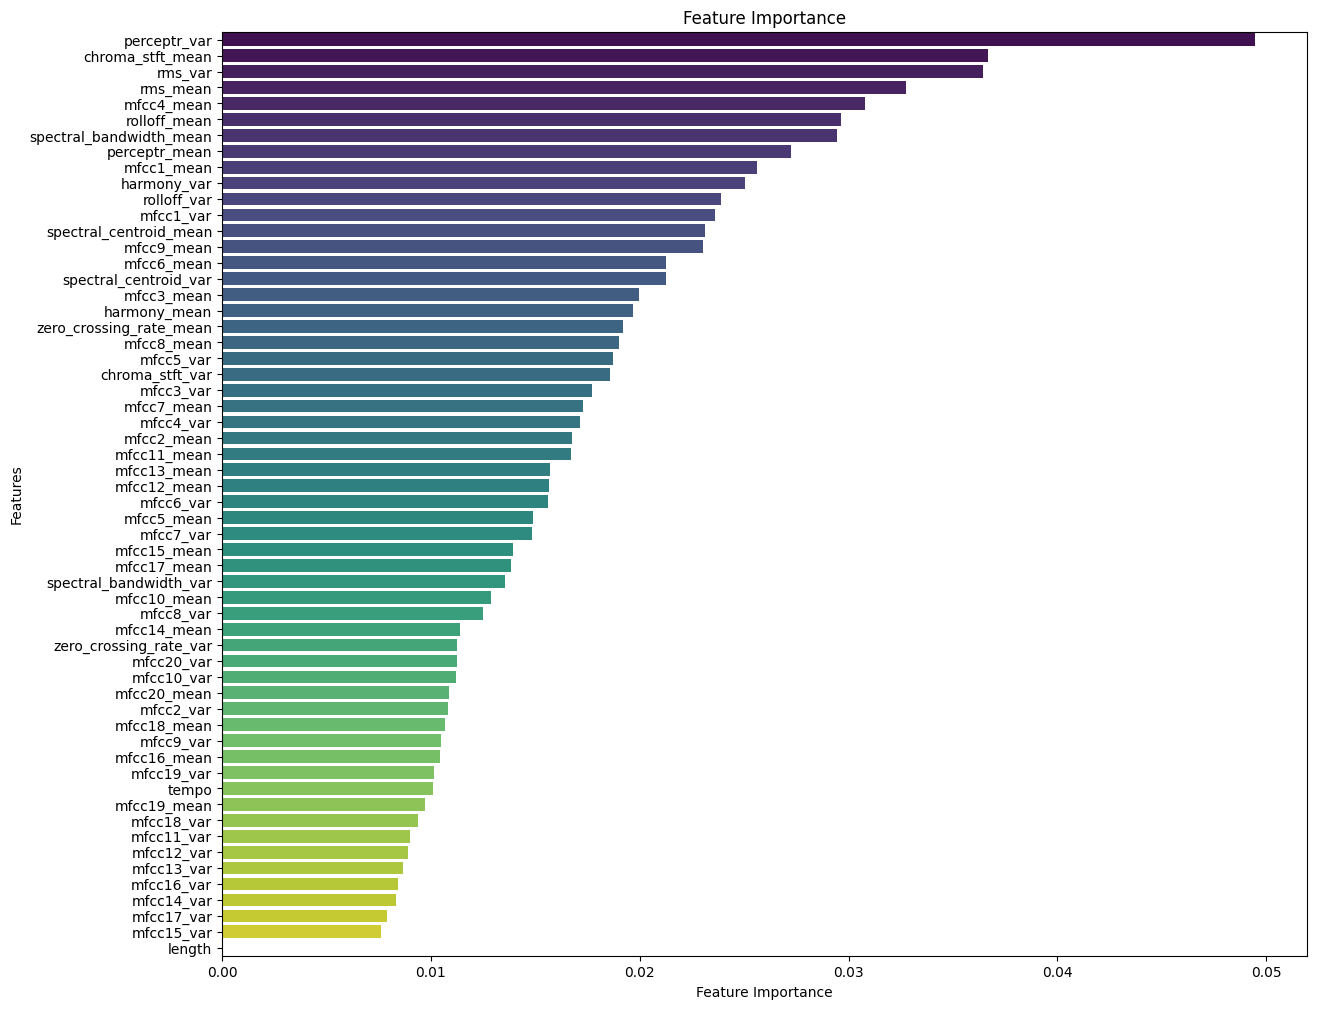

In [18]:
#Visualize Feature Importances #24
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})


feature_importances=feature_importances.sort_values(by="importance" ,ascending =False)

#plot

plt.figure(figsize=(14,12))
sns.barplot(x="importance", y="feature", data=feature_importances, palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.show()

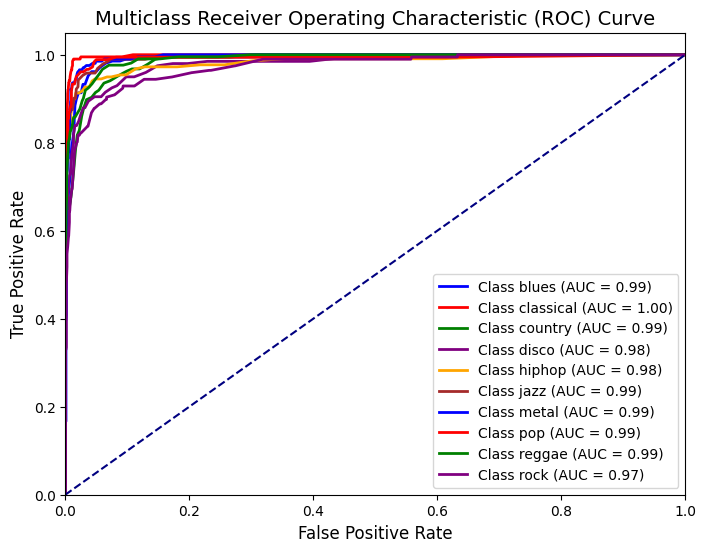

In [21]:
#Create a function to plot the ROC curve for the model. #29
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_multiclass_roc(model, X_test, y_test, class_labels):

    # Binarize the labels
    y_test_bin = label_binarize(y_test, classes=class_labels)
    n_classes = y_test_bin.shape[1]

    # Get predicted probabilities
    y_probs = model.predict_proba(X_test)

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
                 label=f"Class {class_labels[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

    # Labels and title
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title("Multiclass Receiver Operating Characteristic (ROC) Curve", fontsize=14)
    plt.legend(loc="lower right")
    plt.show()

class_labels = np.unique(y_test)

# Call the function
plot_multiclass_roc(rf_model, X_test, y_test, class_labels)

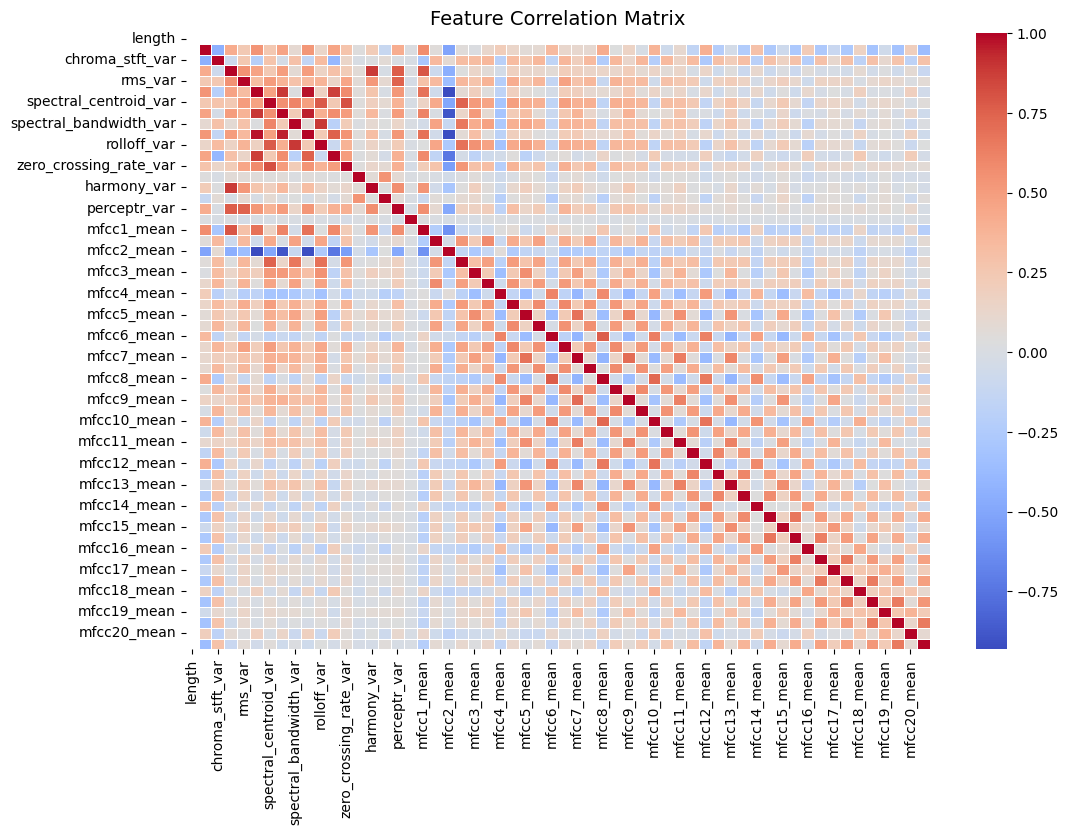

In [23]:
#Use sns.heatmap to visualize the correlation matrix of features in the dataset. #31

import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_matrix(data):
    plt.figure(figsize=(12, 8))
    correlation_matrix = data.corr()

    # Plot heatmap
    sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Feature Correlation Matrix", fontsize=14)
    plt.show()

plot_correlation_matrix(X)


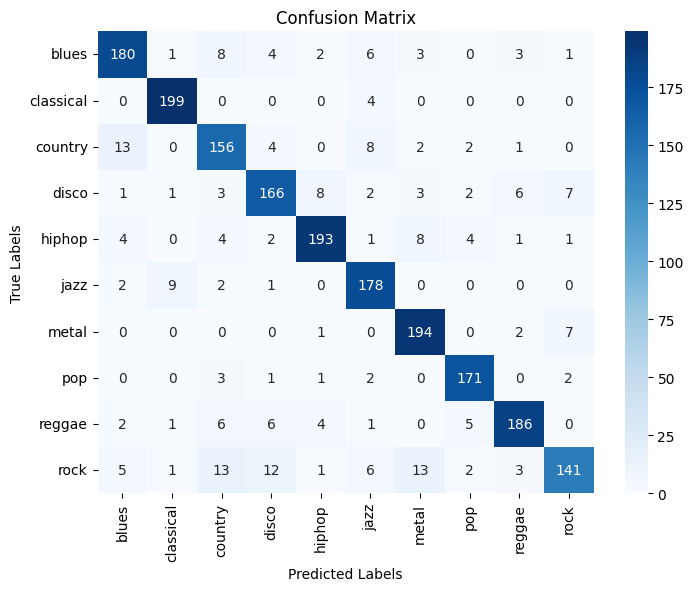

In [24]:
#Visualize the Confusion Matrix #25

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_labels):

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

class_labels = y.unique()
plot_confusion_matrix(y_test, y_pred, class_labels)
